# Bag of Words & Static Embeddings

### Data Read-in

In [1]:
import pandas as pd

# Read in documents. Here, an example list of 100 sentences on NLP generated by Copilot. We only use the first 10 here
docs = pd.read_csv('data/example_sentences.csv')['sentence'].tolist()[0:10]

docs

['NLP stands for Natural Language Processing.',
 'NLP is a field of artificial intelligence.',
 'Understanding human language is the goal of NLP.',
 'NLP can be used to analyze text data.',
 'Sentiment analysis is a common NLP task.',
 'Chatbots use NLP to understand user input.',
 'Machine translation is an application of NLP.',
 'NLP helps in summarizing large documents.',
 'Text classification is a fundamental NLP task.',
 'Named entity recognition identifies proper nouns in text.']

## BoW

In [2]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer
vectorizer = CountVectorizer()

# Create Bag of Words model
X = vectorizer.fit_transform(docs)

# Convert BoW from a compressed sparse matrix a (sparse) DataFrame for better readability
bow_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

print(bow_df)

   an  analysis  analyze  application  artificial  be  can  chatbots  \
0   0         0        0            0           0   0    0         0   
1   0         0        0            0           1   0    0         0   
2   0         0        0            0           0   0    0         0   
3   0         0        1            0           0   1    1         0   
4   0         1        0            0           0   0    0         0   
5   0         0        0            0           0   0    0         1   
6   1         0        0            1           0   0    0         0   
7   0         0        0            0           0   0    0         0   
8   0         0        0            0           0   0    0         0   
9   0         0        0            0           0   0    0         0   

   classification  common  ...  task  text  the  to  translation  understand  \
0               0       0  ...     0     0    0   0            0           0   
1               0       0  ...     0     0    0

### Cosine Similarity

Cosine similarity is defined as the cosine of the angle between vectors. It ranges between [-1,1] and depends on their angle. However, in NLP tasks such as these, the cosine similarity typically ranges between [0,1], as the word count cannot be negative. For example, the maximum difference between two documents is a cosine similarity of 0 if no common words are present. A cosine similarity of 1 means the two documents are identical.


Mathematically, the cosine similarity between two n-dimensional vectors **u** and **v** is represented using a dot product and magnitude:

$$
\text{Cosine Similarity} = \frac{{\mathbf{u} \cdot \mathbf{v}}}{{\| \mathbf{u} \| \times \| \mathbf{v} \|}}
$$

While the dot product $ \mathbf{u}  \cdot  \mathbf{v} $ measures the *similarity in the direction of two vector* and is computed as the sum of the element-wise products of vectors' entries, the magnitude (also called the Euclidean Norm) $\| \mathbf{u} \| \times \| \mathbf{v} \|$ measures the *distance from the origin in the n-dimensional space*. Adding it to the denominator makes the cosine similarity metric *scale invariant* (insensitive to the lengths/magnitudes of **u** and **v**).



In [3]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate the cosine similarity matrix
cosine_sim = cosine_similarity(bow_df)

# Convert to DataFrame for readability
cosine_sim_df = pd.DataFrame(cosine_sim, index=[f'Doc {i}' for i in range(len(bow_df))],
                             columns=[f'Doc {i}' for i in range(len(bow_df))])

print(cosine_sim_df)

          Doc 0     Doc 1     Doc 2     Doc 3     Doc 4     Doc 5     Doc 6  \
Doc 0  1.000000  0.166667  0.288675  0.144338  0.166667  0.154303  0.154303   
Doc 1  0.166667  1.000000  0.433013  0.144338  0.333333  0.154303  0.462910   
Doc 2  0.288675  0.433013  1.000000  0.125000  0.288675  0.133631  0.400892   
Doc 3  0.144338  0.144338  0.125000  1.000000  0.144338  0.267261  0.133631   
Doc 4  0.166667  0.333333  0.288675  0.144338  1.000000  0.154303  0.308607   
Doc 5  0.154303  0.154303  0.133631  0.267261  0.154303  1.000000  0.142857   
Doc 6  0.154303  0.462910  0.400892  0.133631  0.308607  0.142857  1.000000   
Doc 7  0.166667  0.166667  0.144338  0.144338  0.166667  0.154303  0.154303   
Doc 8  0.166667  0.333333  0.288675  0.288675  0.500000  0.154303  0.308607   
Doc 9  0.000000  0.000000  0.000000  0.125000  0.000000  0.000000  0.000000   

          Doc 7     Doc 8     Doc 9  
Doc 0  0.166667  0.166667  0.000000  
Doc 1  0.166667  0.333333  0.000000  
Doc 2  0.144338 

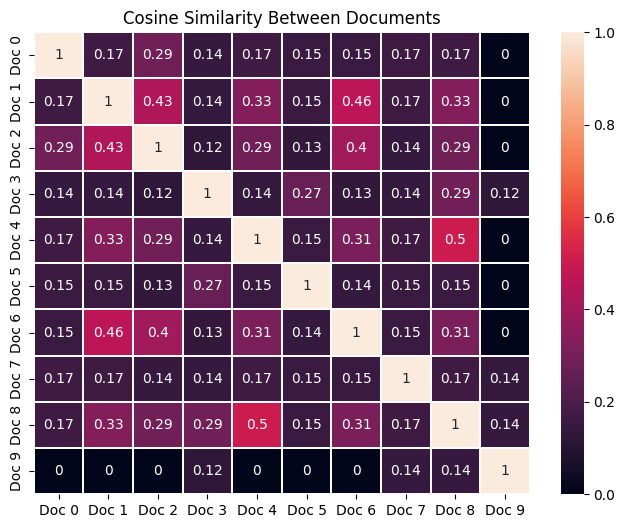

In [4]:
# Plot as heatmap

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cosine_sim_df, annot=True, linewidths=0.1)
plt.title('Cosine Similarity Between Documents')
plt.show()

Note that the similarity between documents here is solely dependant on the word counts in each document. As is typical for Bag of Words appraoches, context, word similarity (e.g. synonyms or typos), and word order are ignored. For example, "He is great" and "He is not great" would rank very similarly.

## Static Word Embeddings

We'll be using Word2Vec here. Note that we do not go into detail on how this algorithm works. For an in-depth look on its workings, I recommend [this article](https://medium.com/@bradneysmith/word-embeddings-with-word2vec-from-scratch-in-python-eb9326c6ab7c).

In [5]:
# We first need to tokenize the documents

import nltk
from nltk.tokenize import word_tokenize

# Download the tokenizer models
nltk.download('punkt_tab')

# Tokenize the documents
tokenized_documents = [word_tokenize(doc.lower()) for doc in docs]

tokenized_documents

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Tim\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


[['nlp', 'stands', 'for', 'natural', 'language', 'processing', '.'],
 ['nlp', 'is', 'a', 'field', 'of', 'artificial', 'intelligence', '.'],
 ['understanding', 'human', 'language', 'is', 'the', 'goal', 'of', 'nlp', '.'],
 ['nlp', 'can', 'be', 'used', 'to', 'analyze', 'text', 'data', '.'],
 ['sentiment', 'analysis', 'is', 'a', 'common', 'nlp', 'task', '.'],
 ['chatbots', 'use', 'nlp', 'to', 'understand', 'user', 'input', '.'],
 ['machine', 'translation', 'is', 'an', 'application', 'of', 'nlp', '.'],
 ['nlp', 'helps', 'in', 'summarizing', 'large', 'documents', '.'],
 ['text', 'classification', 'is', 'a', 'fundamental', 'nlp', 'task', '.'],
 ['named',
  'entity',
  'recognition',
  'identifies',
  'proper',
  'nouns',
  'in',
  'text',
  '.']]

### Custom Model

It is very easy to train a Vec2Word Model from your own corpus. However, the results will be highly dependant on your corpus!

In [ ]:
# Train a custom word2vec model

from gensim.models import Word2Vec

word2vec_model = Word2Vec(sentences=tokenized_documents, # tokenized documents (model input)
                          vector_size=100, # number of embedding dimensions
                          window=5, # context window size (nr of words to the left and right)
                          min_count=0, # drop words occuring fewer than this
                          workers=1) # number of CPU threads to use for training

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
print(f"Embedding Vector for 'nlp':\n{word2vec_model.wv['nlp']}")

In [ ]:
# we can also find the most similar vectors, that is, words

n = 5
word = "nlp"

print(f"{n} most similar words to {word}:\n{word2vec_model.wv.most_similar(word, topn=n)}")

We can also plot the similarity of words. As it is rather impossible to plot in 300 dimensions, however, we first need to reduce the dimensions. There are numerous techniques available, here we'll use Principal Component Analysis (PCA)

In [ ]:
# plot the word embeddings in 2D space wiht PCA

from sklearn.decomposition import PCA

# Get all word vectors
word_vectors = word2vec_model.wv.vectors

# Apply PCA to reduce the dimensionality to 2D
pca = PCA(n_components=2)
word_vectors_2d = pca.fit_transform(word_vectors)

# Create a DataFrame for the 2D word vectors
word_vectors_2d_df = pd.DataFrame(word_vectors_2d, index=word2vec_model.wv.index_to_key, columns=['x', 'y'])

# Plot the 2D word vectors
plt.figure(figsize=(8, 6))
plt.scatter(word_vectors_2d_df['x'], word_vectors_2d_df['y'], alpha=0.5)

# Annotate each point with the word
for word, (x, y) in word_vectors_2d_df.iterrows():
    plt.annotate(word, (x, y))

**Important Note:** When training on very large datasets (as is usually necessary for a balanced outcome), there are certain things to consider, such as RAM usage, training epochs, etc., which we did not cover here. Hauke Licht has a great tutorial on these things I recommend checking out when planning to train your own corpus: https://github.com/haukelicht/advanced_text_analysis/blob/main/notebooks/word_embedding_training_word2vec.ipynb

### Pre-trained Model

There is also a large number of pre-trained models available. Some were trained with Word2Vec, while some used different algorithms. They are easily available for download via Gensim,

In [ ]:
import gensim.downloader as api

# List of all available models
for model_name in list(api.info()['models'].keys()):
  print(model_name)



In [ ]:
# Load the classic google news 300 word2vec model. Note that this model is rather large (1.6gb download)
word2vec = api.load('word2vec-google-news-300')

In [ ]:
# if we want to see where the model was downloaded to, we have to check gensim's base directory

import os

# get path
print(api.BASE_DIR)

# list contents
os.listdir(api.BASE_DIR)

In [ ]:
# print some information about the model
## the actual embeddings are stored in word2vec.vectors - an array by the shape vocabulary_size x embedding_dimensions
print(f"Vocabulary size: {word2vec.vectors.shape[0]}\nEmbedding Dimensions: {word2vec.vectors.shape[1]}")

In [ ]:
# we can also access embeddings for single words with the word2vec.get_vector method
word2vec.get_vector('NLP')

In [ ]:
# index_to_key and key_to_index hold the mapping between words and their indices
word2vec.key_to_index['NLP']

*Important:* Note that the model only holds a limited vocabulary size - in this case, 3.000.000. While this may seem like lot, it is not exhaustive. Also note that this may be case-sensitive. For example, the word "nlp" is not in the corpus, while "NLP" is. Words not in the vocabulary cannot be processed with this model!

As the google-news-300 model differentiates between casing (including some words an all caps), it is advised to not set the input data to lower case before analysis.

In [ ]:
# Extract the individual words from the list of documents

words = list(set(word for doc in docs for word in word_tokenize(doc)))

words

Note the different results in plotting when compared to our custom model

In [ ]:
# plot the word embeddings in 2D space wiht PCA

from sklearn.decomposition import PCA
import numpy as np

# Filter out words that are not in the word2vec model
words_in_model = [word for word in words if word in word2vec.key_to_index]

# Get relevant word vectors from the pre-trained model 
word_vectors = np.array([word2vec[w] for w in words_in_model])

# Apply PCA to reduce the dimensionality to 2D
pca = PCA(n_components=2)
word_vectors_2d = pca.fit_transform(word_vectors)

# Create a DataFrame for the 2D word vectors
word_vectors_2d_df = pd.DataFrame(word_vectors_2d, index=words_in_model, columns=['x', 'y'])

# Plot the 2D word vectors
plt.figure(figsize=(8, 6))
plt.scatter(word_vectors_2d_df['x'], word_vectors_2d_df['y'], alpha=0.5)

# Annotate each point with the word
for word, (x, y) in word_vectors_2d_df.iterrows():
    plt.annotate(word, (x, y))

Note that some tokens are not present in the model. This includes stopwords (of, a, to) and punctuation, but also the word "Chatbots".

In [ ]:
# print words in words not in words_in_model
print(f"Tokens not present in the model: {[word for word in words if word not in words_in_model]}")

## Word Similarity

We can use **Cosine Similarity** to compare any two vectors in our model. Note that, while the principle is the same as in the BoW model above, there are two key differences:

a) While we were comparing *Documents* in the BoW model (with each vector representing word occurrences in a document), we now compare *Words* in the embedding space (with each vector representing a word's values in each of the embedding dimensions)

b) While the cosine similarity in BoW models could only be *positive* because word counts cannot be negative, the values in the embedding dimensions can be negative, allowing cosine similarity in word embedding models to be *positive or negative*.

*Gensim* provides numerous convenience functions to compare words in the embedding space using cosine similarity. Note that these are methods applied to the specific embedding model, hence `word2vec` here refers to the google-news-300 model, while `word2vec_model` would refer to our custom model.

In [ ]:
# Computing the cosine similarity between two words

word2vec.similarity('good', 'bad')

In [ ]:
# we can do this for multiple words at once with a simple loop

word = 'good'
comparisons = ['bad', 'great', 'terrible', 'awesome']

for comparison in comparisons:
    similarity = word2vec.similarity(word, comparison)
    print(f"Similarity between '{word}' and '{comparison}': {similarity}")

We can also find nearest neighbors (i.e., most similar words) utilizing cosine similarity. Technically, this works by computing the cosine similarities between a word and all other words in the model. *Gensim* offers a convenient function for this.

In [ ]:
word2vec.most_similar('good', topn=5) # topn denotes the number of most similar words to return

### Finding Analogies

We can also use the `most_similar` method to find analogies. Technically, this means finding a word that has a similar relationship to a given word as two other given words. Solving this problem is one of the strengths (and was one of the breakthroughs) of static word embeddings (Word2Vec in particular), because it proves that the model is good at encoding similar words with similar vectors. 

The analogy task is typicall defined as:

> X1 is to Y1 as X2 is to Y2.

A common problem, for example, would be:

> Man is to woman as king is to ____? 

Or, more formally:

> King - Man + Woman = Queen

The syntax for solving this problem with `most_similar` is as follows:

`most_similar(positive=[X2, Y1], negative=[X1], topn=n)` 

with the function returning the n most likely candidates for Y2. Notice how this negative/positive syntax relies on the formal notation, namely 

> X2 - X1 + Y1 = Y2

In practice:

In [ ]:
word2vec.most_similar(positive=['king', 'woman'], negative=['man'], topn=5)

### Other Functions

*Gensim* has a large number of other functions to compare words in an embedding model, including cosine distances (the inverse of cosine similarity). For an overview, and why all of these functions technically run on keyed vectors, see: https://radimrehurek.com/gensim/models/keyedvectors.html

## Model Bias

As mentioned before, the embeddings are highly dependant on the texts they were trained on. **_This makes it especially important to think about what you want to measure, and if the embeddings you use can introduce bias to your measurement!_**

Let's take a look at gender bias in the google-news-300 model.

In [ ]:
terms = ["man","woman"]
comparison_words = ["programmer", "scientist", "intelligent", "caring", "nurse", "parent", "doctor", "teacher", "driver", "engineer"]

for comparison in comparison_words:
    for term in terms:
        similarity = word2vec.similarity(term, comparison)
        print(f"Similarity between '{term}' and '{comparison}': {similarity}")

However, this dependance on the training texts can be used to our advantage. For example, we can train two sets of word embeddings on two different corpora, and compare their vectors. Likewise, we can use this method to track shifts in language use.

More on Bias in Models: https://doi.org/10.1145/3514094.3534162

Tracking Gender Stereotypes over Time with Word Embeddings: https://doi.org/10.1073/pnas.1720347115